In [13]:
import pandas as pd # Importing requireq libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px
warnings.filterwarnings('ignore')

In [14]:
exchange = pd.read_csv('/content/exchange_rate.csv') #Importing dataset
exchange

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [15]:
exchange.info() #Get information about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [16]:
exchange['date'] = pd.to_datetime(exchange['date'],format='%d-%m-%Y %H:%M') # Convert the date column to datetime format

In [17]:
exchange.info() #Check the data type of the date column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     7588 non-null   datetime64[ns]
 1   Ex_rate  7588 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 118.7 KB


In [18]:
px.line(exchange,x='date',y='Ex_rate',template='plotly_dark') #ploting line plot

In [19]:
exchange.isna().sum() #Check for missing values

,0
date,0
Ex_rate,0


In [20]:
px.box(exchange['date']) #Check for outliers


In [21]:
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [22]:
from statsmodels.tsa.stattools import adfuller

In [23]:
# Check for stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\	{key}: {value}')

In [24]:
print("Stationarity Test for Original Series:")
test_stationarity(exchange['Ex_rate'])

Stationarity Test for Original Series:
ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477
Critical Values:
\	1%: -3.4312123140180137
\	5%: -2.861921078147796
\	10%: -2.5669728434336108


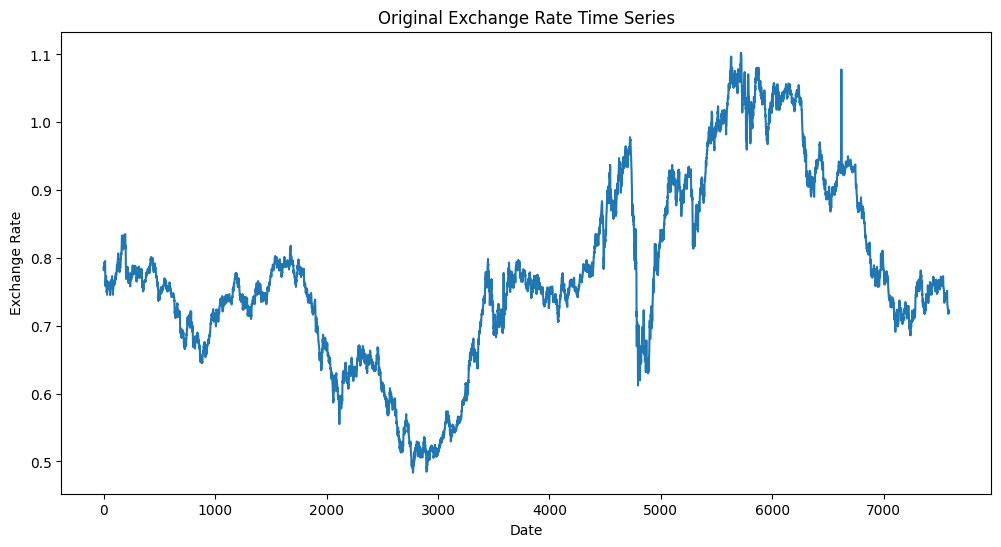

In [25]:
# Plot original series
plt.figure(figsize=(12, 6))
plt.plot(exchange.index, exchange['Ex_rate'])
plt.title('Original Exchange Rate Time Series')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.show()

In [26]:
# Calculate first difference
exchange['first_difference'] = exchange['Ex_rate'].diff()

print("Stationarity Test for First Difference:")
exchange['first_difference'].dropna()

Stationarity Test for First Difference:


,first_difference
1,-0.003700
2,0.004900
3,-0.000700
4,-0.001100
5,0.001700
...,...
7583,-0.000207
7584,0.003345
7585,0.001358
7586,-0.002372


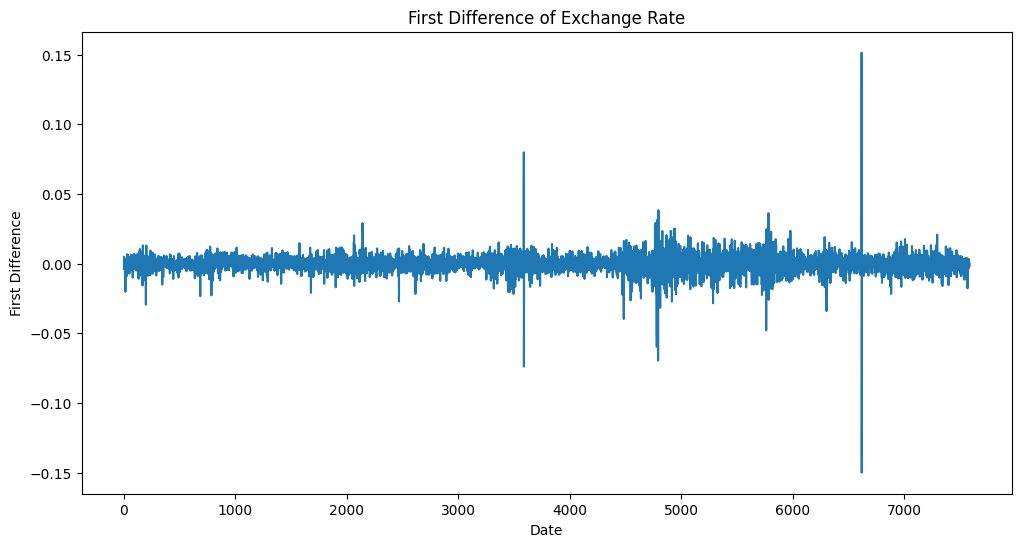

In [27]:
# Plot first difference
plt.figure(figsize=(12, 6))
plt.plot(exchange.index[1:], exchange['first_difference'][1:])
plt.title('First Difference of Exchange Rate')
plt.xlabel('Date')
plt.ylabel('First Difference')
plt.show()

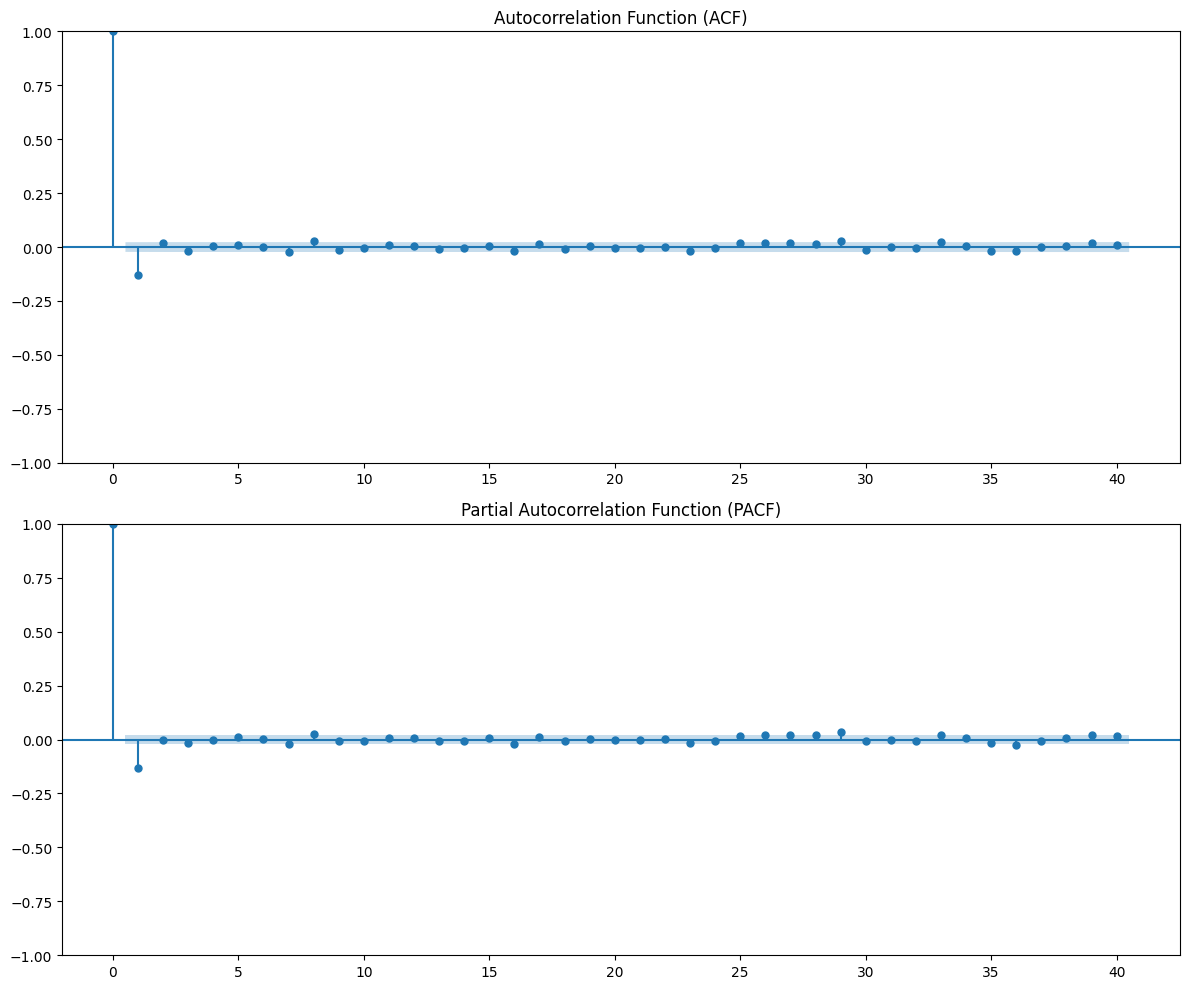

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(exchange['first_difference'].dropna(), ax=ax1, lags=40)
ax1.set_title('Autocorrelation Function (ACF)')
plot_pacf(exchange['first_difference'].dropna(), ax=ax2, lags=40)
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

In [29]:
from statsmodels.tsa.arima.model import ARIMA # Importing requireq libraries
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.model_selection import train_test_split

In [30]:
train_data, test_data = train_test_split(exchange['Ex_rate'], test_size=0.2, shuffle=False,random_state=42) # Splitting the data into train and test

In [31]:
model = ARIMA(train_data, order=(1, 1, 1))
results = model.fit()

In [32]:
residuals = results.resid
lb_test_stat, lb_test_p_value = acorr_ljungbox(residuals, lags=20)

In [34]:
# Check the p-values to assess autocorrelation
for p_val_str in lb_test_p_value:
    if p_val_str != 'l' and p_val_str != 'b':
        # If a numeric p-value is found, break out of the loop
        break
    # Increase the order of the ARIMA model by incrementing p and q
    order = (order[0] + 1, 1, order[2] + 1)
    model = ARIMA(train_data, order=order)
    results = model.fit()

    # Perform Ljung-Box test again
    residuals = results.resid
    lb_test_stat, lb_test_p_value = acorr_ljungbox(residuals, lags=20)

# Print the final order of the ARIMA model
print("Final order of ARIMA model (p, d, q):", order)

NameError: name 'order' is not defined

In [ ]:
# Fit the ARIMA model
model = ARIMA(exchange['Ex_rate'], order=(3, 1, 3))
results = model.fit()

In [ ]:
residuals = results.resid

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(residuals, color='blue')
plt.title('Residuals of ARIMA Model')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(residuals, lags=50, ax=ax[0])
plot_pacf(residuals, lags=50, ax=ax[1])
plt.show()

In [ ]:
from scipy import stats
# Ljung-Box test for autocorrelation
lb_test_stat, lb_test_p_value = acorr_ljungbox(residuals, lags=20)
print('Ljung-Box Test (Residuals):')
print('Lag\tStatistic\tP-value')
for lag, stat, p_value in zip(range(1, 21), lb_test_stat, lb_test_p_value):
    if isinstance(stat, (int, float)) and isinstance(p_value, (int, float)):
        print(f'{lag}\t{stat:.2f}\t{p_value:.2f}')
    else:
        print(f'{lag}\t{stat}\t{p_value}')

# Normality test (Jarque-Bera test)
jb_test = stats.jarque_bera(residuals)
print('\nJarque-Bera Test (Residuals):')
print('JB Statistic:', jb_test[0])
print('p-value:', jb_test[1])

In [ ]:
import plotly.graph_objects as go

In [ ]:
trace_actual = go.Scatter(x=exchange['date'], y=exchange['Ex_rate'])
trace_forecast = go.Scatter(x=exchange['date'], y=exchange['Ex_rate'])

# Show plot
fig = go.Figure(data=[trace_actual, trace_forecast])
fig.update_layout(title='Actual vs Forecasted Exchange Rate',
                   xaxis_title='Date',
                   yaxis_title='Exchange Rate')

# Show plot
fig.show()

In [ ]:
# Visualize the time series data
plt.figure(figsize=(12, 6))
plt.plot(exchange['date'], exchange['Ex_rate'], color='blue')
plt.title('Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(exchange['Ex_rate'], lags=50, ax=ax[0])
plot_pacf(exchange['Ex_rate'], lags=50, ax=ax[1])
plt.show()

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error

In [ ]:
model = SimpleExpSmoothing(train_data)
model_fit = model.fit()

In [ ]:

predictions = model_fit.forecast(len(test_data))

In [ ]:
mse = mean_squared_error(test_data, predictions)
print('Mean Squared Error:', mse)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Testing Data', color='green')
plt.plot(test_data.index, predictions, label='Predictions', color='red')
plt.title('Actual vs Predicted Exchange Rate (Simple Exponential Smoothing)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
alpha_values = np.arange(0.1, 1.1, 0.1)  # Smoothing level
best_mse = float('inf')
best_params = None

In [ ]:
for alpha in alpha_values:
    # Fit Simple Exponential Smoothing model with current parameter
    model = SimpleExpSmoothing(train_data)
    model_fit = model.fit(smoothing_level=alpha)

    # Make predictions
    predictions = model_fit.forecast(len(test_data))

    # Calculate Mean Squared Error
    mse = mean_squared_error(test_data, predictions)

    # Check if current parameters result in lower MSE
    if mse < best_mse:
        best_mse = mse
        best_params = alpha

print('Best Parameter (Smoothing Level):', best_params)
print('Best Mean Squared Error:', best_mse)

In [ ]:
from statsmodels.tsa.holtwinters import Holt

In [ ]:
model_with_trend = Holt(train_data)
model_fit_with_trend = model_with_trend.fit(smoothing_level=0.4, smoothing_trend=0.2, optimized=False)

In [ ]:
predictions_with_trend = model_fit_with_trend.forecast(len(test_data))

In [ ]:
mse_with_trend = mean_squared_error(test_data, predictions_with_trend)
print('Mean Squared Error (with trend):', mse_with_trend)

In [ ]:
model = Holt(exchange['Ex_rate'])
model_fit = model.fit(smoothing_level=0.4, smoothing_trend=0.2, optimized=False)

In [ ]:
forecast_values = model_fit.forecast(steps=100)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(exchange['date'], exchange['Ex_rate'], label='Actual', color='blue')
plt.plot(pd.date_range(start=exchange['date'].iloc[-1], periods=101, freq='D')[1:], forecast_values, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Exchange Rate Forecast with Holt\'s Linear Trend Method')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
mae_ses = mean_absolute_error(test_data, predictions)
print('Mean Absolute Error (SES):', mae_ses)

# Calculate RMSE for Simple Exponential Smoothing
rmse_ses = np.sqrt(mean_squared_error(test_data, predictions))
print('Root Mean Squared Error (SES):', rmse_ses)

# Calculate MAPE for Simple Exponential Smoothing
mape_ses = np.mean(np.abs((test_data - predictions) / test_data)) * 100
print('Mean Absolute Percentage Error (SES):', mape_ses)

In [ ]:
mae_holt = mean_absolute_error(test_data, predictions_with_trend)
print('Mean Absolute Error (Holt):', mae_holt)

# Calculate RMSE for Holt's Linear trend model
rmse_holt = np.sqrt(mean_squared_error(test_data, predictions_with_trend))
print('Root Mean Squared Error (Holt):', rmse_holt)

# Calculate MAPE for Holt's Linear trend model
mape_holt = np.mean(np.abs((test_data - predictions_with_trend) / test_data)) * 100
print('Mean Absolute Percentage Error (Holt):', mape_holt)

In [ ]:
# # **Model Comparison**

# #Simple Exponential Smoothing (SES)
# **Performance:**

# MAE: 0.1776
# RMSE: 0.2054
# MAPE: 22.79%
# SES exhibits a moderate performance, with a relatively high MAPE indicating that the model's predictions are on average 22.79% off from the actual values.

# **Advantages:**

# Simplicity: SES is the most straightforward forecasting method and is easy to implement.
# Effectiveness for stationary data: It performs well for data without any trend or seasonality.

# **Limitations:**

# Inability to capture trends or seasonality: SES cannot effectively model data with time-dependent patterns.
# Sensitivity to initial value: The initial value used in the smoothing equation significantly impacts the model's predictions.

# # Holt's Linear Method
# **Performance:**

# MAE: 0.1298
# RMSE: 0.1499
# MAPE: 16.63%
# Holt's Linear Method demonstrates improved performance compared to SES, with lower error metrics. The MAPE of 16.63% suggests that the model's predictions are generally closer to the actual values.

# **Advantages:**

# Handles trends: Holt's Linear Method can effectively model data with linear trends.
# Flexibility: It allows for adjusting the smoothing parameters to fit different data characteristics.

# **Limitations:**

# **Assumes linear trends:** If the underlying trend is non-linear, Holt's Linear Method may not capture the pattern accurately.
# **Cannot handle seasonality**: Similar to SES, it does not account for seasonal patterns in the data.

# **Conclusion**:

# Holt's Linear Method outperforms SES in terms of accuracy, especially in capturing the trend component of the data. While SES is suitable for stationary data, Holt's Linear Method is a better choice when dealing with data exhibiting linear trends.